# March Machine Learning Madness 2024: 
### Predicting NCAA Basketball Tournament Results
##### From the [Kaggle Competition](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/overview) by the same name
##### By David Hartsman

<hr style="border: 4px solid blue">

In [20]:
# Imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import warnings

warnings.filterwarnings("ignore")

### Exploration of the Various Data Files
There are 32 separate data sources that require exploration and understanding. I will begin my project by inspecting the contents of these files to understand the information contained within. The first file contains information about `THIS YEAR'S` tournament seeds.

In [2]:
# Using os and this path to make pd.read_csv() statements more concise 
path = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/NCAA_KAGGLE/march-machine-learning-mania-2024'

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Data Section 1:</b> The Basics
</div>

 1. **M/W Teams**
 2. **M/W Seasons**
 3. **M/W Tournament Seeds**
 4. **M/W `RegularSeason` CompactResults**
 5. **M/W `NCAATourney` CompactResults**


<hr style="border: 2px solid blue">

##### 1.) M/W Teams
- TeamID -> Unique Identifier
- TeamName -> String Name
- FirstD1Season -> Year of said-season
- LastD1Season -> 2024 if currently D1, else final year as D1 school

In [52]:
# Load
men_teams = pd.read_csv(os.path.join(path, 'MTeams.csv'))

# Inspect
men_teams.shape, men_teams.head()

((378, 4),
    TeamID     TeamName  FirstD1Season  LastD1Season
 0    1101  Abilene Chr           2014          2024
 1    1102    Air Force           1985          2024
 2    1103        Akron           1985          2024
 3    1104      Alabama           1985          2024
 4    1105  Alabama A&M           2000          2024)

In [56]:
# Very few schools have cycled out of D1 eligibility 
men_teams["LastD1Season"].value_counts(normalize=False)

LastD1Season
2024    362
1991      2
1987      2
2023      2
2006      1
1992      1
2011      1
1990      1
2003      1
1998      1
1985      1
2019      1
2010      1
1986      1
Name: count, dtype: int64

<hr style="border: 2px solid blue">

##### 2.) Seasons
- Season -> int, year
- DayZero -> First day of given season
- RegionW -> name of each specific region, in the future, data will be organized by 'WXYZ' regions, not "Midwest", etc.
- RegionX -> same
- RegionY -> same
- RegionZ -> same

In [60]:
# Load - parsing dates as DayZero is a specific datetime, might be needed later
mens_seasons = pd.read_csv(os.path.join(path, "MSeasons.csv"), parse_dates=["DayZero"])
# Inspect
mens_seasons.shape, mens_seasons.head()

((40, 6),
    Season    DayZero RegionW    RegionX    RegionY    RegionZ
 0    1985 1984-10-29    East       West    Midwest  Southeast
 1    1986 1985-10-28    East    Midwest  Southeast       West
 2    1987 1986-10-27    East  Southeast    Midwest       West
 3    1988 1987-11-02    East    Midwest  Southeast       West
 4    1989 1988-10-31    East       West    Midwest  Southeast)

In [61]:
mens_seasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Season   40 non-null     int64         
 1   DayZero  40 non-null     datetime64[ns]
 2   RegionW  40 non-null     object        
 3   RegionX  40 non-null     object        
 4   RegionY  40 non-null     object        
 5   RegionZ  40 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.0+ KB


<hr style="border: 2px solid blue">

##### 3.) Seeds:
This data contain 128 rows, 64 for each tournament, men's and women's respectively. The 
- `Tournament` column designates M/W for men or women, 
- `Seed` contains bracket region and numeric seeds, and 
- `TeamID`, contains what may be a unique identifier for merging

In [3]:
# Load data
tournament_seeds = pd.read_csv(os.path.join(path, '2024_tourney_seeds.csv'))

# Inspect the DF contents
tournament_seeds.shape, tournament_seeds.head()

((128, 3),
   Tournament Seed  TeamID
 0          M  W01    1345
 1          M  W02    1266
 2          M  W03    1243
 3          M  W04    1397
 4          M  W05    1181)

<hr style="border: 2px solid blue">

##### 4.) Regular Season Compact Results
- Season -> int, year
- DayNum -> 0 - 132 (Selection Sunday)
- WTeamID -> unique key
- WScore -> int, winning score
- LTeamID -> unique key
- LScore -> int, losing score
- WLoc -> location (Home/Away/Neutral]) of the winning team
- NumOT -> int, number of overtime periods in the game

In [63]:
# Load
mens_reg_seas_compact = pd.read_csv(os.path.join(path, 'MRegularSeasonCompactResults.csv'))

# Inspect
mens_reg_seas_compact.shape, mens_reg_seas_compact.head()

((186552, 8),
    Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
 0    1985      20     1228      81     1328      64    N      0
 1    1985      25     1106      77     1354      70    H      0
 2    1985      25     1112      63     1223      56    H      0
 3    1985      25     1165      70     1432      54    H      0
 4    1985      25     1192      86     1447      74    H      0)

<hr style="border: 2px solid blue">

##### 5.) Men's NCAA `Tourney` Compact Results
Many familiar features that will be used for joining
- Season
- DayNum -> because these are tourney games, they are all `GREATER THAN` 132
- WTeamID
- WScore -> score content
- LTeamID
- LScore -> losing score
- WLoc -> Winner's Respective Location 'H' for Home, 'A' for Away, 'N' for neutral, ALMOST ALL NEUTRAL FOR TOURNEY
- NumOT - number of overtime periods in the game, might want to create features based off of this column


In [41]:
# Load
men_ncaa_compact_results = pd.read_csv(os.path.join(path, 'MNCAATourneyCompactResults.csv'))
# Inspect
men_ncaa_compact_results.shape, men_compact_results.head()

((2451, 8),
    Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
 0    1985     136     1116      63     1234      54    N      0
 1    1985     136     1120      59     1345      58    N      0
 2    1985     136     1207      68     1250      43    N      0
 3    1985     136     1229      58     1425      55    N      0
 4    1985     136     1242      49     1325      38    N      0)

In [68]:
# WTeamID = 1104 for the ONE home game... Somehow Alabama had a home game in 2023

men_ncaa_compact_results.query("WLoc == 'H'"), men_teams.query("TeamID == 1104") 

(      Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
 2388    2023     136     1104      96     1394      75    H      0,
    TeamID TeamName  FirstD1Season  LastD1Season
 3    1104  Alabama           1985          2024)

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Data Section 2:</b> Team Box Scores
</div>

 1. **M/W Regular Season Detailed Results**
 2. **M/W NCAA Tourney Detailed Results**

<hr style="border: 2px solid blue">

##### 1.) Regular Season Detailed Results
There are a lot of statistics tracked in this dataframe. The first 8 columns are the same as the compact results files. The remainder of the columns are typical counting stats that you find in a box score. 

In [69]:
# Load
mens_reg_seas_detailed = pd.read_csv(os.path.join(path, "MRegularSeasonDetailedResults.csv"))

# Inspect
mens_reg_seas_detailed.shape, mens_reg_seas_detailed.head()

((112504, 34),
    Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
 0    2003      10     1104      68     1328      62    N      0    27    58   
 1    2003      10     1272      70     1393      63    N      0    26    62   
 2    2003      11     1266      73     1437      61    N      0    24    58   
 3    2003      11     1296      56     1457      50    N      0    18    38   
 4    2003      11     1400      77     1208      71    N      0    30    61   
 
    ...  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
 0  ...     10    16    22   10   22     8   18     9     2   20  
 1  ...     24     9    20   20   25     7   12     8     6   16  
 2  ...     26    14    23   31   22     9   12     2     5   23  
 3  ...     22     8    15   17   20     9   19     4     3   23  
 4  ...     16    17    27   21   15    12   10     7     1   14  
 
 [5 rows x 34 columns])

<hr style="border: 2px solid blue">

##### 2.) NCAA Tournament Detailed Results
34 Feature Columns, data doesn't go back as far (2003 vs 1985) as NCAA compact results, WTeamID/LTeamID available. This data looks to have the most pertinent features thus far.

In [47]:
# Load
men_ncaa_detailed_results = pd.read_csv(os.path.join(path, 'MNCAATourneyDetailedResults.csv'))
# Inspect
men_ncaa_detailed_results.shape, men_ncaa_detailed_results.head()

((1315, 34),
    Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
 0    2003     134     1421      92     1411      84    N      1    32    69   
 1    2003     136     1112      80     1436      51    N      0    31    66   
 2    2003     136     1113      84     1272      71    N      0    31    59   
 3    2003     136     1141      79     1166      73    N      0    29    53   
 4    2003     136     1143      76     1301      74    N      1    27    64   
 
    ...  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
 0  ...     31    14    31   17   28    16   15     5     0   22  
 1  ...     16     7     7    8   26    12   17    10     3   15  
 2  ...     28    14    21   20   22    11   12     2     5   18  
 3  ...     17    12    17   14   17    20   21     6     6   21  
 4  ...     21    15    20   10   26    16   14     5     8   19  
 
 [5 rows x 34 columns])

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Data Section 3:</b> Geography
</div>

 1. **M/W Cities**
 2. **M/W Game Cities**


<hr style="border: 2px solid blue">

##### 1.) Cities: 
This df is 483 rows and 3 columns, and it contains
- `CityID` key which may be a unique identifier that can be used for merging tables, 
- `City` name, and 
- `State` name 

In [70]:
# Load data
cities = pd.read_csv(os.path.join(path, 'Cities.csv'))

# Inspect the DF contents
cities.shape, cities

((483, 3),
      CityID          City State
 0      4001       Abilene    TX
 1      4002         Akron    OH
 2      4003        Albany    NY
 3      4004   Albuquerque    NM
 4      4005     Allentown    PA
 ..      ...           ...   ...
 478    4501        Destin    FL
 479    4502  South Easton    MA
 480    4503      Cherokee    NC
 481    4504    St. Joseph    MO
 482    4505         Paris    FR
 
 [483 rows x 3 columns])

<hr style="border: 2px solid blue">

##### 2.) City Game Locations:
- Season: Year game was played
- DayNum: 0-132, 132 being Selection Sunday
- WTeamID: Winning Team
- LTeamID: Losing Team
- CRType: Relates to a corresponding file, regular secondary or ncaa
- CityID: Location

In [7]:
# Load Data
mens_city_games = pd.read_csv(os.path.join(path, 'MGameCities.csv'))

# Inspect Data
mens_city_games.shape, mens_city_games.head()

((80170, 6),
    Season  DayNum  WTeamID  LTeamID   CRType  CityID
 0    2010       7     1143     1293  Regular    4027
 1    2010       7     1314     1198  Regular    4061
 2    2010       7     1326     1108  Regular    4080
 3    2010       7     1393     1107  Regular    4340
 4    2010       9     1143     1178  Regular    4027)

In [9]:
mens_city_games["CRType"].value_counts()

CRType
Regular      78430
Secondary      873
NCAA           867
Name: count, dtype: int64

In [ ]:
# Load data
cities = pd.read_csv(os.path.join(path, 'Cities.csv'))

# Inspect the DF contents
cities.shape, cities

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Data Section 4:</b> Public Rankings
</div>

 1. **M/W  MMasseyOrdinals**


<hr style="border: 2px solid blue">

##### 1.) M_Massey : 
This file lists out rankings (e.g. #1, #2, #3, ..., #N) of men's teams going back to the 2002-2003 season, under a large number of different ranking system methodologies. The information was gathered by Kenneth Massey and provided on his College Basketball Ranking Composite page.
- Season
- RankingDayNum -> going to want to use the final day, possibly generate a `MOVING AVERAGE FEATURE` later
- SystemName -> Ranking system name - 192 distinct ranking systems
- TeamID - self-explanatory
- OrdinalRank - 1 through Total Number of Active Programs usually around 346

In [12]:
# Load Data
m_massey = pd.read_csv(os.path.join(path, 'MMasseyOrdinals.csv'))

# Inspect - 5.2M rows
m_massey.shape, m_massey.head()

((5204627, 5),
    Season  RankingDayNum SystemName  TeamID  OrdinalRank
 0    2003             35        SEL    1102          159
 1    2003             35        SEL    1103          229
 2    2003             35        SEL    1104           12
 3    2003             35        SEL    1105          314
 4    2003             35        SEL    1106          260)

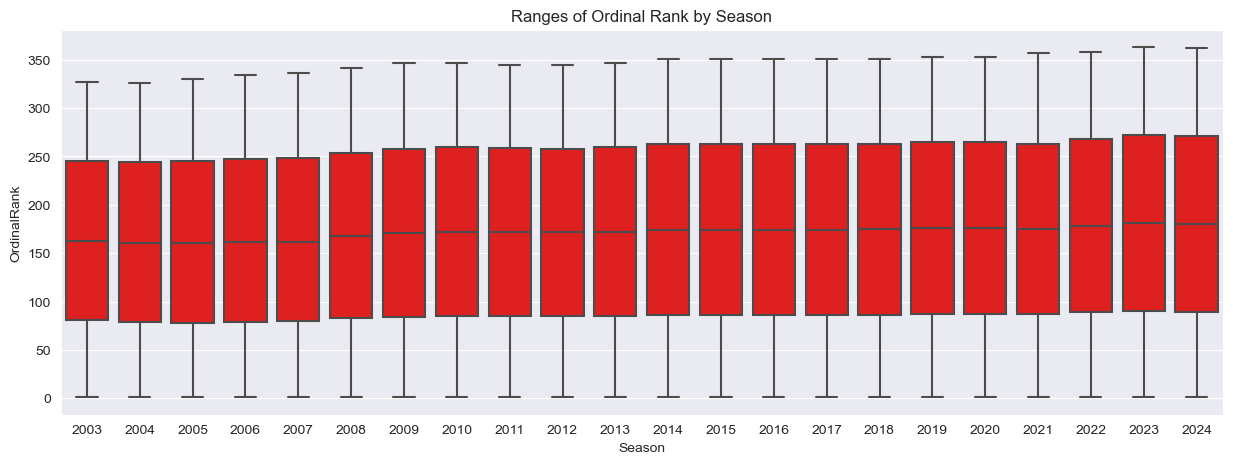

In [90]:
# Visual Inspection of Ordinal Rank
fig, ax = plt.subplots(figsize=(15,5))
sns.set_style("darkgrid")
sns.boxplot(x="Season", y="OrdinalRank", data=m_massey, color="red", ax=ax)
ax.set_title("Ranges of Ordinal Rank by Season");

In [37]:
# Possible means to consolidate the ranking systems, - computation heavy cell, so commented out

# top_20_systems = list(m_massey["SystemName"].value_counts(normalize=True)[:20].index)
# m_massey["SystemName"].apply(lambda x: x if x in top_20_systems else "Other").value_counts()[:5]

SystemName
Other    3210065
MOR       135173
POM       132682
SAG       130371
DOK       119386
Name: count, dtype: int64

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Data Section 5:</b> Supplemental Info
</div>

 1. **Men's Coaches (only men)**
 2. **Conferences**
 3. **M/W Teams Conferences (additional detail)**
 4. **Men's Conference Tournament Games**
 5. **Men's Secondary Tourney Teams**
 6. **Men's Sec Tourney Compact Results**
 7. **M/W Team Spellings**
 8. **M/W NCAA Tourney Slots**
 9. **Men's NCAA Tourney Seed Round Slots**


<hr style="border: 2px solid blue">

##### 1.) Men's Coaches
Use `Season`, `TeamID` to merge data on.

In [91]:
# Load
mens_coaches = pd.read_csv(os.path.join(path, 'MTeamCoaches.csv'))
# Inspect
mens_coaches.shape, mens_coaches.head()

((13167, 5),
    Season  TeamID  FirstDayNum  LastDayNum       CoachName
 0    1985    1102            0         154   reggie_minton
 1    1985    1103            0         154     bob_huggins
 2    1985    1104            0         154  wimp_sanderson
 3    1985    1106            0         154    james_oliver
 4    1985    1108            0         154   davey_whitney)

<hr style="border: 2px solid blue">

##### 2.) Conferences:
51 rows, 2 columns for each distinct conference. 
- `ConfAbbrev` containing lowercase abbreviation, and 
- `Description` containing the full length conference name. 

In [5]:
# Load Data
conferences = pd.read_csv(os.path.join(path, 'Conferences.csv'))

# Inspect Data
conferences.shape, conferences.head()

((51, 2),
   ConfAbbrev                   Description
 0      a_sun       Atlantic Sun Conference
 1      a_ten        Atlantic 10 Conference
 2        aac  American Athletic Conference
 3        acc     Atlantic Coast Conference
 4        aec       America East Conference)

<hr style="border: 2px solid blue">

##### 3.) M/W Team Conferences
- Season
- TeamID
- ConfAbbrev -> used to access the "Description" from above dataframe: Full Name String

In [92]:
# Load
mens_conferences = pd.read_csv(os.path.join(path, 'MTeamConferences.csv'))
# Inspect
mens_conferences.shape, mens_conferences.head()

((13024, 3),
    Season  TeamID ConfAbbrev
 0    1985    1102        wac
 1    1985    1103        ovc
 2    1985    1104        sec
 3    1985    1106       swac
 4    1985    1108       swac)

<hr style="border: 2px solid blue">

##### 4.) Men's Conference Tourney Games:
- `Season` Year of Record
- `ConfAbbrev` same as "conferences" df ConfAbbrev columns
- `DayNum` this integer always ranges from 0 to 132, day 132 is always SELECTION SUNDAY, day 0 is earliest first game of ALL seasons in the data
- `WTeamID` winning team ID for merging data
- `LTeamID` also for merging data

In [46]:
# Load Data
mens_conference_tourney_games = pd.read_csv(os.path.join(path, 'MConferenceTourneyGames.csv'))

# Inspect Data
mens_conference_tourney_games.shape, mens_games.head(6)

((6189, 5),
    Season ConfAbbrev  DayNum  WTeamID  LTeamID
 0    2001      a_sun     121     1194     1144
 1    2001      a_sun     121     1416     1240
 2    2001      a_sun     122     1209     1194
 3    2001      a_sun     122     1359     1239
 4    2001      a_sun     122     1391     1273
 5    2001      a_sun     122     1407     1416)

<hr style="border: 2px solid blue">

##### 5.) Men's Secondary Tourney Teams

<hr style="border: 2px solid blue">

<hr style="border: 2px solid blue">

<hr style="border: 2px solid blue">

##### Men's City Game Locations:
- Season: Year game was played
- DayNum: 0-132, 132 being Selection Sunday
- WTeamID: Winning Team
- LTeamID: Losing Team
- CRType: Relates to a corresponding file, regular secondary or ncaa
- CityID: Location

In [7]:
# Load Data
mens_city_games = pd.read_csv(os.path.join(path, 'MGameCities.csv'))

# Inspect Data
mens_city_games.shape, mens_city_games.head()

((80170, 6),
    Season  DayNum  WTeamID  LTeamID   CRType  CityID
 0    2010       7     1143     1293  Regular    4027
 1    2010       7     1314     1198  Regular    4061
 2    2010       7     1326     1108  Regular    4080
 3    2010       7     1393     1107  Regular    4340
 4    2010       9     1143     1178  Regular    4027)

In [9]:
mens_city_games["CRType"].value_counts()

CRType
Regular      78430
Secondary      873
NCAA           867
Name: count, dtype: int64

<hr style="border: 2px solid blue">

<hr style="border: 2px solid blue">

<hr style="border: 2px solid blue">

##### Tournament Seed Rounded Slots
Kind of strange data to consolidate. 

In [51]:
men_tourney_seed_rounded_slots = pd.read_csv(os.path.join(path, 'MNCAATourneySeedRoundSlots.csv'))
men_tourney_seed_rounded_slots.shape, men_tourney_seed_rounded_slots.head()

((720, 5),
   Seed  GameRound GameSlot  EarlyDayNum  LateDayNum
 0  W01          1     R1W1          136         137
 1  W01          2     R2W1          138         139
 2  W01          3     R3W1          143         144
 3  W01          4     R4W1          145         146
 4  W01          5     R5WX          152         152)